# Figures S5. Evaluation of PIML-predicted Jezica on Jiusti dataset

Make sure environment is using `glasspy 0.4.6`.

In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np

from utils import get_gs, get_eta_tl, get_gfa

In [2]:
myrcparams = {
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

In [3]:
cols = ['Tg', 'Tc', 'Tx', 'Tl', 'T_Umax', 'log_Umax']
titles = ['$T_g$', '$T_c$', '$T_x$', '$T_l$', '$T_{max(U)}$', '$log(U_{max})$']

# Data

## Load GlassNet training and test data

In [4]:
glassnet_no_stnn = GlassNet(st_models=[])
glassnet_stnn = GlassNet()
glassnet_test_df = glassnet_stnn.get_test_dataset()
glassnet_train_df = glassnet_stnn.get_training_dataset()

In [5]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [6]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)
X_glassnet_feats_total, feats = glassnet_stnn.featurizer(X_glassnet_total, return_cols = True)

In [7]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)
X_glassnet_feats_total = pd.DataFrame(X_glassnet_feats_total, columns = feats)

In [8]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index
X_glassnet_feats_total.index = X_glassnet_total.index

In [9]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_glassnet_train.Tliq, composition = X_glassnet_train)
y_glassnet_test['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_glassnet_test.Tliq, composition = X_glassnet_test)
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/scipy/optimize/_lsq/least_squares.py:221: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


In [10]:
gs_glassnet_train = get_gs(y_glassnet_train )
gs_glassnet_test = get_gs( y_glassnet_test )
gs_glassnet_total = pd.concat( (gs_glassnet_train, gs_glassnet_test) )

## Load Jiusti data

In [13]:
benchmark_df = pd.read_csv('../data/jiusti.csv',sep=";") # Table 2
benchmark_df.rename(columns={'Tg (K)': 'Tg', 'Tx (K)': 'Tx', 'Tc (K)': 'Tc', 'Tl (K)': 'Tliq', 'T(Umax) (K)': 'T_Umax',
                             'Umax (m s−1)': 'Umax'}, inplace=True)
benchmark_df['log10 (η∞)'] = benchmark_df['log10 (η∞)'].str.replace('−', '-').astype('float')
benchmark_titles_temps = [r'$T_g$', r'$T_x$', r'$T_c$', r'$T_l$', r'$T_{Umax}$', r'$T_{12}$']
benchmark_df['ViscosityAtTl'] = get_eta_tl(benchmark_df)
benchmark_df['log_Umax'] = np.log( benchmark_df.Umax.str.replace('E', 'e').str.replace('−', '-').values.astype(float) )
benchmark_glassnet_feats = [ glassnet_stnn.featurizer(comp, return_cols = False)[0] for comp in benchmark_df.Glass ]
benchmark_glassnet_feats = pd.DataFrame( np.vstack( benchmark_glassnet_feats ), columns = feats )

In [14]:
gs_benchmark = get_gs( benchmark_df, jez=True )
gfa_benchmark = get_gfa( benchmark_df)

In [15]:
y_pred_benchmark_glassnet = pd.concat( [ glassnet_stnn.predict(comp) for comp in benchmark_df.Glass ] ).reset_index(drop=True).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})

# GlassNet and RF predictions of Jezica

In [16]:
rf = RandomForestRegressor()
col = ['Tliq']
this_y_train = y_glassnet_train[col].dropna()
this_X_train = X_glassnet_feats_train.loc[ this_y_train.index, : ]
this_y_test = y_glassnet_test[col].dropna()
this_X_test = X_glassnet_feats_test.loc[ this_y_test.index, : ]

rf.fit(this_X_train, this_y_train)

/var/folders/lc/m_z4zy9x62x6ly0p54t47jnh0000gp/T/ipykernel_18606/4195890325.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(this_X_train, this_y_train)


RandomForestRegressor()

In [17]:
y_pred_benchmark_rf = rf.predict( benchmark_glassnet_feats )

In [18]:
y_pred_benchmark_glassnet['ViscosityAtTl'] = [ glassnet_stnn.predict_log10_viscosity(T = y_pred_benchmark_glassnet.loc[i,'Tliq'],
                                                                          composition = comp) for i,comp in enumerate(benchmark_df.Glass) ]

In [19]:
rf_viscosity = [ glassnet_stnn.predict_log10_viscosity(T = y_pred_benchmark_rf[i],
                                                                          composition = comp) for i,comp in enumerate(benchmark_df.Glass) ]

In [20]:
y_pred_benchmark_rf = pd.DataFrame( np.column_stack( (y_pred_benchmark_rf, rf_viscosity) ), columns = ['Tliq', 'ViscosityAtTl'] )

In [21]:
jezica_pred_glassnet = [i[0] for i in (y_pred_benchmark_glassnet.ViscosityAtTl) - 2 * np.log10(y_pred_benchmark_glassnet.Tliq)]
jezica_pred_rf = (y_pred_benchmark_rf.ViscosityAtTl) - 2 * np.log10(y_pred_benchmark_rf.Tliq)

# Figure S5

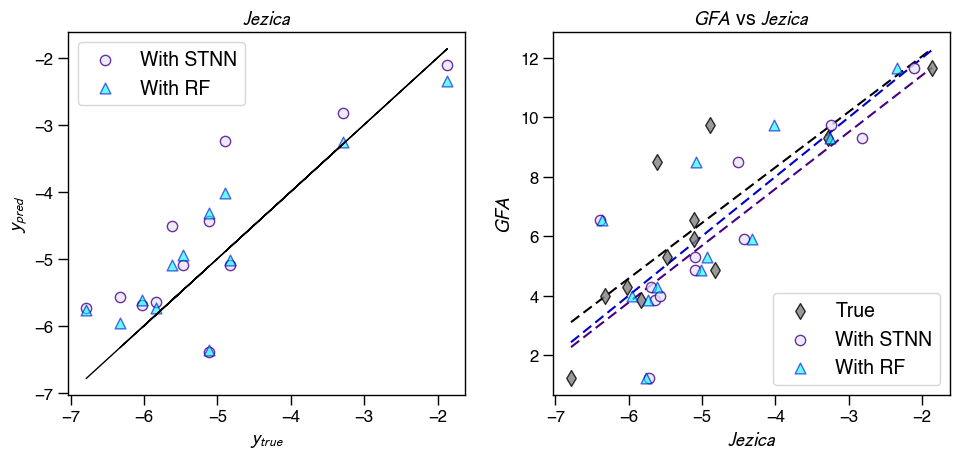

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].scatter(gs_benchmark.Jezica, jezica_pred_glassnet, marker='o', s=55, alpha=0.8, color='lavender', edgecolor='indigo', label='With STNN')
ax[0].scatter(gs_benchmark.Jezica, jezica_pred_rf, marker='^', s=60, alpha=0.6, color='cyan', edgecolor='mediumblue', label='With RF')
ax[0].plot(gs_benchmark.Jezica, gs_benchmark.Jezica, color='black',linewidth=1.0)
ax[0].set_xlabel(r'$y_{true}$')
ax[0].set_ylabel(r'$y_{pred}$')
ax[0].set_title('$Jezica$')
ax[0].legend()

m_true, b_true = np.polyfit(gs_benchmark.Jezica.values, gfa_benchmark.GFA.values, 1)
m_glassnet, b_glassnet = np.polyfit(jezica_pred_glassnet, gfa_benchmark.GFA.values, 1)
m_rf, b_rf = np.polyfit(jezica_pred_rf.values, gfa_benchmark.GFA.values, 1)
x = np.linspace( min(gs_benchmark.Jezica), max(gs_benchmark.Jezica), 100)
y_true = m_true*x+b_true
y_glassnet = m_glassnet*x+b_glassnet
y_rf = m_rf*x+b_rf

ax[1].plot(x,y_true,color='black', linestyle='dashed')
ax[1].plot(x,y_glassnet,color='indigo', linestyle='dashed')
ax[1].plot(x,y_rf,color='mediumblue', linestyle='dashed')
ax[1].scatter(gs_benchmark.Jezica, gfa_benchmark.GFA, marker='d', s=65, alpha=0.8, color='gray', edgecolor='black', label='True', zorder=3 )
ax[1].scatter(jezica_pred_glassnet, gfa_benchmark.GFA, marker='o', s=55, alpha=0.8, color='lavender', edgecolor='indigo', label='With STNN', zorder=3)
ax[1].scatter(jezica_pred_rf, gfa_benchmark.GFA, marker='^', s=60, alpha=0.6, color='cyan', edgecolor='mediumblue', label='With RF', zorder=3)
ax[1].set_xlabel(r'$Jezica$')
ax[1].set_ylabel(r'$GFA$')
ax[1].set_title('$GFA$ vs $Jezica$')
ax[1].legend()
fig.savefig('figures5.png', dpi=600)

In [23]:
print(m_true, m_glassnet, m_rf)

1.868982801705517 1.9108775052911373 1.9980045049924609


In [24]:
kendalltau( gs_benchmark.Jezica, gfa_benchmark.GFA )

SignificanceResult(statistic=0.6666666666666666, pvalue=0.0018032758136924804)

In [25]:
kendalltau( jezica_pred_glassnet, gfa_benchmark.GFA )

SignificanceResult(statistic=0.6363636363636362, pvalue=0.003181646992410881)

In [26]:
kendalltau( jezica_pred_rf, gfa_benchmark.GFA )

SignificanceResult(statistic=0.606060606060606, pvalue=0.005380307706696595)